<img src="aiayn.png">

> When teaching, I emphasize implementation as a way to understand recent developments in ML. This post is an attempt to keep myself honest along this goal. The recent ["Attention is All You Need"]
(https://arxiv.org/abs/1706.03762) paper from NIPS 2017 has been instantly impactful paper as a new method for machine translation and potentiall NLP generally. The paper is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly. 
>
> In this post I follow the paper through from start to finish and try to implement each component in code. 
(I have done some minor reordering and skipping from the original paper). This document itself is a working notebook, and should be a completely usable and efficient implementation. To follow along you will first need to install [PyTorch](http://pytorch.org/) and [torchtext](https://github.com/pytorch/text). The complete code is available on [github](https://github.com/harvardnlp/annotated-transformer).
>- Alexander "Sasha" Rush ([@harvardnlp](https://twitter.com/harvardnlp))


In [2]:
!pip install numpy matplotlib spacy torchtext 

In [1]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt


* Table of Contents                               
{:toc}      

# Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU
[16], ByteNet [18] and ConvS2S [9], all of which use convolutional neural networks as basic building
block, computing hidden representations in parallel for all input and output positions. In these models,
the number of operations required to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes
it more difficult to learn dependencies between distant positions [12]. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of reduced effective resolution due
to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as
described in section 3.2.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, abstractive summarization,
textual entailment and learning task-independent sentence representations [4, 27, 28, 22].
End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned
recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks [34].

To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequencealigned
RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].

# Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](cho2014learning,bahdanau2014neural,sutskever14). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](graves2013generating), consuming the previously generated symbols as additional input when generating the next. 

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively. 

<img src="ModalNet-21.png" width=400px>

## Encoder and Decoder Stacks   

### Encoder: 

The encoder is composed of a stack of $N=6$ identical layers. 

In [3]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [4]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection [(cite)](he2016deep) around each of the two sub-layers, followed by layer normalization [(cite)](layernorm2016).  

In [5]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](srivastava2014dropout) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

In [6]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [7]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder:

The decoder is also composed of a stack of $N=6$ identical layers.  


In [8]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

In [9]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [10]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

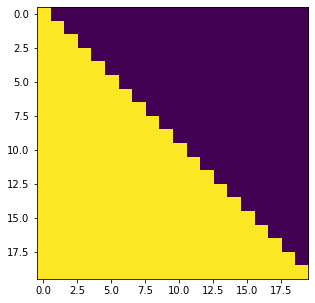

In [11]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training. 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### Attention:                                                                                                                                                                                                                                                                               
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                           

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                         
<img width="220px" src="ModalNet-19.png">

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$                                                                                                                                                                                                        
                                                                                                                                                                     

In [12]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention [(cite)](bahdanau2014neural), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

                                                                        
While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](DBLP:journals/corr/BritzGLL17). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

### Multi-Head Attention                                                                                                                                                                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively.                                                                                                                                                                                                   
On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values:

<img width="270px" src="ModalNet-20.png">
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                                                                                                                                                                                                                                                                             
    
    
   
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                                                                                        
   

   
In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.   

In [13]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Applications of Attention in our Model                                                                                                                                                      
The Transformer uses multi-head attention in three different ways:                                                        
1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [(cite)](wu2016google, bahdanau2014neural,JonasFaceNet2017).    


2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   


3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                                                                                                                                                      

## Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [14]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](press2016using). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                                                                                                                                 

In [15]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](JonasFaceNet2017). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                                                                                                                                                                                                                                                                                                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                                                                                                                                                                                                                                                                                                                                                                                                                                       
$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [16]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

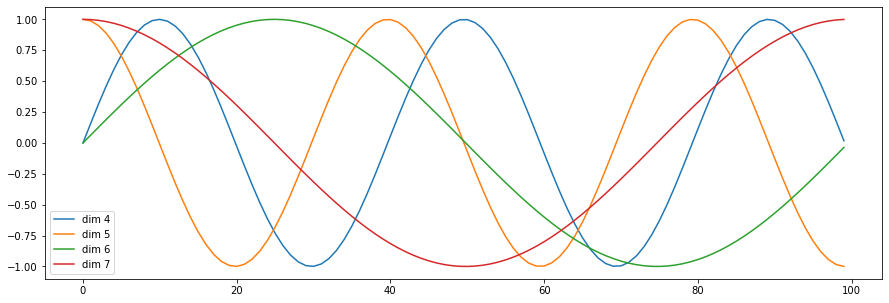

In [17]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings [(cite)](JonasFaceNet2017) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

## Generation

In [18]:
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Full Model

In [19]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [20]:
# Small example model.
tmp_model = make_model(10, 10, 2)
tmp_model

<ipython-input-19-aa9f90f53c3a>:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=Fals

# Training

This section describes the training regime for our models.


## Training Data and Batching

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs.  Sentences were encoded using byte-pair encoding \citep{DBLP:journals/corr/BritzGLL17}, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary [(cite)](wu2016google). 


Sentence pairs were batched together by approximate sequence length.  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.     

## Hardware and Schedule                                                                                                                                                                                                   
We trained our models on one machine with 8 NVIDIA P100 GPUs.  For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds.  We trained the base models for a total of 100,000 steps or 12 hours.  For our big models, step time was 1.0 seconds.  The big models were trained for 300,000 steps (3.5 days).

## Optimizer

We used the Adam optimizer [(cite)](kingma2014adam) with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:                                                                                            
$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.                            

In [21]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

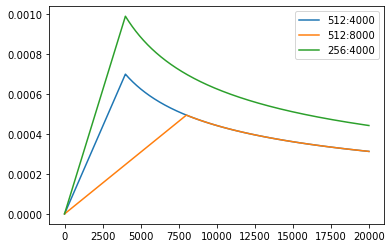

In [22]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## Regularization                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                      
### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](DBLP:journals/corr/SzegedyVISW15).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

In [23]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/home/ocistudent/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


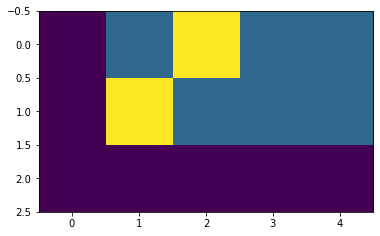

In [24]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [25]:
# Label smoothing starts to penalize the model 
# if it gets very confident about a given choice
crit = LabelSmoothing(5, 0, 0.2)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

### Memory Optimization

In [26]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

In [27]:
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

In [28]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)

In [29]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
        

In [30]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

In [31]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(data_gen(V, 30, 20), model, criterion, model_opt)

<ipython-input-19-aa9f90f53c3a>:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

# A Real World Example

In [32]:
# For data loading.
from torchtext import data, datasets, legacy


In [28]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 17.1MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=e8095324edd05fde2767f4a9a51215f3bcd2bdb4416a9014ce4653b3d1e27572
  Stored in directory: /tmp/pip-ephem-wheel-cache-olatbk_7/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [33]:
# Load words from IWSLT

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
print()
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = legacy.data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = legacy.data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100

train, val, test = datasets.IWSLT2017(root='.data', split=('train', 'valid', 'test'), language_pair=('de', 'en'))
#train, val, test = datasets.IWSLT2017(exts=('.de', '.en'), fields=(SRC, TGT), 
#                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
#                                        len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 1
SRC.build_vocab(train, min_freq=MIN_FREQ)
TGT.build_vocab(train, min_freq=MIN_FREQ)

2017-01-trnmted.tgz: 329MB [00:35, 9.31MB/s] 


In [35]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.

BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(legacy.data.iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

TypeError: module() takes at most 2 arguments (3 given)

In [ ]:
# Create the model an load it onto our GPU.
pad_idx = TGT.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
model_opt = get_std_opt(model)
model.cuda()

AssertionError: ignored

In [ ]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)

1 9.299771845340729 6.987712429686844e-07
11 9.415135336574167 4.192627457812107e-06
21 8.813630282878876 7.686483672655528e-06
31 9.112178653478622 1.118033988749895e-05
41 8.607461810112 1.4674196102342371e-05
51 8.913826749660075 1.8168052317185794e-05
61 8.701497752219439 2.1661908532029216e-05
71 8.373274087905884 2.515576474687264e-05
81 8.454237446188927 2.8649620961716057e-05
91 7.6996782422065735 3.214347717655948e-05
101 8.037408232688904 3.56373333914029e-05
111 7.704962134361267 3.913118960624633e-05
121 7.699015600606799 4.262504582108975e-05
131 7.367554426193237 4.611890203593317e-05
141 7.2071177661418915 4.961275825077659e-05
151 7.106400920893066 5.310661446562001e-05
161 6.804656069725752 5.660047068046343e-05
171 6.390337720513344 6.0094326895306855e-05
181 5.687528342008591 6.358818311015028e-05
191 6.122820109128952 6.70820393249937e-05
201 5.829070374369621 7.057589553983712e-05



OTHER

In [ ]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [ ]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

1


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512)
            (1): Linear(in_features=512, out_features=512)
            (2): Linear(in_features=512, out_features=512)
            (3): Linear(in_features=512, out_features=512)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=512)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
        )
      )
      (1): EncoderLayer(
        (self_attn): MultiH

In [ ]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [ ]:
print(pad_idx)
print(len(SRC.vocab))

1
50002


In [ ]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type EncoderDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type EncoderLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type MultiHeadedAttention. It won't be checked f

In [ ]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

1 3.269582842476666 0.0005377044714644026
101 3.300532897672383 0.0005726430336128369
201 3.3047672072425485 0.0006075815957612711
301 2.7151080842595547 0.0006425201579097052
401 2.6975380268413574 0.0006774587200581396
501 3.051631387323141 0.0007123972822065737
601 2.554425454698503 0.000747335844355008
701 2.6254820519825444 0.0007822744065034422
801 2.868743653933052 0.0008172129686518764
901 2.5978208642918617 0.0008521515308003106
1001 2.5955790174775757 0.0008870900929487448
1101 2.6764775353949517 0.000922028655097179
1201 2.464000296778977 0.0009569672172456132
1301 2.0503073083236814 0.0009919057793940475
1401 2.295472824771423 0.0010268443415424816
1501 2.245281406212598 0.0010617829036909158
1601 2.2577588511630893 0.00109672146583935
1701 2.2232908592559397 0.0011316600279877844
1801 2.357596361427568 0.0011665985901362186
1901 2.121352154412307 0.0012015371522846527
2001 2.5742998471250758 0.001236475714433087
2101 2.2518509055953473 0.0012714142765815214
2201 2.22513266

/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  


1 1.5940000533591956 0.0009927515780513657
101 1.7524283765815198 0.0009865483707369156
201 1.900138527940726 0.0009804600111146078
301 1.8419977760640904 0.0009744829985071481
401 1.9621913449373096 0.0009686139798247046
501 2.226916428655386 0.0009628497416600543
601 1.7190162097394932 0.0009571872028951208
701 1.8589106332874508 0.0009516234077802563
801 1.8107321247807704 0.000946155519450957
901 1.6531266793608665 0.0009407808138497059
1001 1.4840005157748237 0.0009354966740233614
1101 1.7578403616789728 0.0009303005847689719
1201 1.3920216620899737 0.0009251901276031373
1301 1.6626927084289491 0.0009201629760320567
1401 1.7256765578058548 0.0009152168911012566
1501 1.6049046433763579 0.0009103497172056578
1601 1.6955451717367396 0.000905559378142174
1701 1.6796367820352316 0.0009008438733884249
1801 1.5794002648835885 0.0008962012745924116
1901 1.9637197174597532 0.0008916297222591652
2001 1.4656428614398465 0.0008871274226214399
2101 1.567156056407839 0.0008826926446824871
2201 

5301 1.2408291140163783 0.0005481296401151859
5401 1.3008261130889878 0.0005470786965145471
5501 1.1700160388209042 0.0005460337748323287
5601 1.2999350049067289 0.000544994817777915
5701 1.3322585223941132 0.0005439617688208604
5801 1.254337038320955 0.0005429345721779703
5901 1.773689029644629 0.000541913172800649
6001 1.3898115772462916 0.0005408975163625087
6101 1.4735579792177305 0.0005398875492472326
6201 1.05738219874911 0.000538883218536687
6301 1.0802461032290012 0.0005378844719992749
1 1.286231731530279 0.0005370101533168812
101 1.2250633136718534 0.0005360217659787991
201 1.239320948603563 0.0005350388161199592
301 1.4140636462761904 0.0005340612540665886
401 1.442663955502212 0.0005330890307779102
501 1.4505203103472013 0.0005321220978358095
601 1.2115196966333315 0.0005311604074347066
701 1.2035035027656704 0.0005302039123716286
801 1.3747974793659523 0.0005292525660364788
901 1.36490419106849 0.0005283063224024965
1001 1.1864821948111057 0.0005273651360169036
1101 1.16233

4101 1.1924936635477934 0.0004215282249101765
4201 1.1275967326655518 0.0004210496830751471
4301 1.0625419117277488 0.0004205727673487576
4401 1.1389823842037003 0.00042009746854249313
4501 1.339291847194545 0.00041962377754036395
4601 1.0302886090357788 0.0004191516852981713
4701 1.7122778899138211 0.00041868118284278167
4801 1.2910672437865287 0.0004182122612714111
4901 1.0494152382598259 0.00041774491175091685
5001 1.1782474033534527 0.0004172791255170995
5101 1.040663594380021 0.0004168148938740118
5201 0.9901199785526842 0.00041635220819327733
5301 1.5490817801910453 0.00041589105991341656
5401 1.1346296942792833 0.00041543144053918197
5501 1.223581779631786 0.00041497334164089994
5601 0.958975835936144 0.0004145167548538224
5701 1.238148811913561 0.0004140616718774844
5801 1.1881117207813077 0.000413608084475071
5901 1.1295715225860476 0.0004131559844727907
6001 1.0610488005331717 0.000412705363759257
6101 1.2371235750615597 0.00041225621428487707
6201 1.1479767516138963 0.000411

2801 1.200010517553892 0.0003554609358465082
2901 1.059172057226533 0.000355173838478046
3001 1.0261963941156864 0.000354887435632968
3101 0.9737269952893257 0.0003546017245155551
3201 1.109491402952699 0.0003543167023458187
3301 1.0379895093501545 0.0003540323663593864
3401 1.0210047286818735 0.00035374871380738974
3501 1.3062616163679195 0.0003534657419563522
3601 1.1297821700572968 0.00035318344808807914
3701 1.095454223890556 0.0003529018294995477
3801 1.0263875699602067 0.00035262088350279793
3901 1.0200049103004858 0.00035234060742482575
4001 1.139240143907955 0.00035206099860747537
4101 1.185085133272878 0.00035178205440733397
4201 1.0887831579057092 0.0003515037721956263
4301 1.7533796445081862 0.000351226149358111
4401 1.1149956742010545 0.00035094918329497705
4501 1.1544227619015146 0.0003506728714207421
4601 1.1121961249154992 0.00035039721116415036
4701 1.0929120010696352 0.0003501221999680728
4801 1.118996370700188 0.000349847835289407
4901 0.9860638748505153 0.00034957411

1501 1.1463393379817717 0.00031309937625977405
1601 1.0650637014914537 0.0003129031224475018
1701 1.1410465109511279 0.00031270723721473664
1801 1.0148204645956866 0.0003125117194092209
1901 0.9743651752360165 0.0003123165678837336
2001 0.990701739974611 0.00031212178149606226
2101 1.1128740338463103 0.00031192735910897496
2201 1.5508626039809315 0.0003117332995901923
2301 1.01486110695987 0.00031153960181235955
2401 0.9611194784665713 0.0003113462646530196
2501 1.0847897573257796 0.0003111532869945851
2601 1.2803321699175285 0.00031096066772431187
2701 1.0769891024538083 0.0003107684057342714
2801 1.0039243546780199 0.00031057649992132457
2901 1.0824949400266632 0.00031038494918709473
3001 0.9644128995714709 0.00031019375243794144
3101 0.9868561172188492 0.00031000290858493437
3201 1.0903575613629073 0.00030981241654382685
3301 1.2633273452374851 0.0003096222752350304
3401 1.0088038056419464 0.000309432483583589
3501 1.1047235757578164 0.0003092430405191533
3601 1.163446888080216 0.00

In [ ]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118